In [3]:
library(sdmpredictors)
library(broom.mixed)
library(ggsignif)
library(lmerTest)
library(multcomp)
library(reshape2)
library(recipes)
library(parsnip)
library(ggpmisc)
library(ggpubr)
library(geodata)
library(ggplot2)
library(stringr)
library(raster)
library(readxl)
library(xtable)
library(broom)
library(dplyr)
library(ade4)
library(caret)
library(ggsci)
library(lme4)
library(nlme)
library(MASS)
library(sf)

Loading required package: lme4

Loading required package: Matrix


Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: 'TH.data'


The following object is masked from 'package:MASS':

    geyser


Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'recipes'


The following object is masked from 'package:lmerTest':

    step


The following object is masked from 'package:Matrix':

    update


The following object is masked from 'package:stats':

    step


Loa

In [31]:
help(sdmpredictors)

In [33]:
citation("sdmpredictors")


To cite package 'sdmpredictors' in publications use:

  Samuel Bosch and Salvador Fernandez (2022). sdmpredictors: Species
  Distribution Modelling Predictor Datasets. R package version 0.2.14.
  https://CRAN.R-project.org/package=sdmpredictors

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {sdmpredictors: Species Distribution Modelling Predictor Datasets},
    author = {Samuel Bosch and Salvador Fernandez},
    year = {2022},
    note = {R package version 0.2.14},
    url = {https://CRAN.R-project.org/package=sdmpredictors},
  }


In [34]:
packageVersion("sdmpredictors")

[1] '0.2.14'

In [2]:
(Bluecarbon_sites <- read.csv("data//BC/BCsampling_sites.tsv", sep ="\t", header=T) %>% 
                    dplyr::mutate(Site = ifelse(Site =="Site1", "Upper", "Lower")) %>%
                    dplyr::rename(estuary = Estuary) %>%
                    dplyr::rename(Biogeographical_region = Biogeographical.region))

estuary,Site,x,y,date,Biogeographical_region
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Berg,Upper,18.19648,-32.81314,18 06 2021,Cool Temperate
Berg,Lower,18.14189,-32.77216,18 06 2021,Cool Temperate
Breede,Lower,20.84452,-34.39693,25 06 2021,Warm temperate
Breede,Upper,20.80405,-34.40552,25 06 2021,Warm temperate
Knysna,Upper,23.05105,-34.06119,30 05 2021,Warm temperate
Knysna,Lower,22.99216,-34.03369,30 05 2021,Warm temperate
Olifants,Lower,18.18882,-31.69302,05 07 2021,Cool Temperate
Olifants,Upper,18.19545,-31.66071,05 07 2021,Cool Temperate
Swartkops,Lower,25.59069,-33.83784,25 05 2021,Warm temperate


In [3]:
sample_n(Bluecarbon_sites, 5)

estuary,Site,x,y,date,Biogeographical_region
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Olifants,Upper,18.19545,-31.66071,05 07 2021,Cool Temperate
Olifants,Lower,18.18882,-31.69302,05 07 2021,Cool Temperate
Swartkops,Upper,25.62139,-33.86114,25 05 2021,Warm temperate
Breede,Upper,20.80405,-34.40552,25 06 2021,Warm temperate
Mngazana,Lower,29.41853,-31.68501,11 10 2021,Subtropical


In [4]:
CHNS_cores <- readRDS(file = "data/BC/CHNS_cores.RDS") %>%
              dplyr::rename(Plot = plot) %>%
              dplyr::mutate(Site = ifelse(Plot == "LWR", "Lower",  "Upper")) %>%
              dplyr::mutate(Site = as.factor(Site)) %>% 
              dplyr::group_by(estuary, Site) %>%
              dplyr::filter(estuary != "Breede" | Site != "Lower") %>%
              dplyr::mutate(Site_Id = as.factor(paste0("Site", cur_group_id()))) %>%
              dplyr::mutate(Site_ref =  glue::glue("{estuary}_{Site_Id}")) %>%
              ungroup()

estuary_levels = c("Olifants", "Berg","Breede","Knysna", "Swartkops","Mngazana")
CHNS_cores$estuary <- factor(CHNS_cores$estuary, levels = estuary_levels)            

In [5]:
ZAF_bluecarbon_raw <- CHNS_cores

In [6]:
xtabs(~ depth + estuary , data = CHNS_cores)

     estuary
depth Olifants Berg Breede Knysna Swartkops Mngazana
   5         8    8      4      8         8       11
   10        8    8      4      8         8       11
   20        8    8      4      8         8       11
   30        8    8      4      8         8       10
   50        8    8      4      8         8        3

In [7]:
xtabs(~ estuary + Site, data = CHNS_cores)

           Site
estuary     Lower Upper
  Olifants     20    20
  Berg         20    20
  Breede        0    20
  Knysna       20    20
  Swartkops    20    20
  Mngazana     26    20

In [8]:
core_count <- ZAF_bluecarbon_raw %>% 
              dplyr::group_by(estuary, Site) %>%
              dplyr::summarise(Cores = n())

BC_samples <- merge(Bluecarbon_sites, core_count) %>%
              dplyr::rename(Long = x, Lat = y) %>%
              dplyr::select(-date) %>%
              dplyr::mutate(estuary = factor(estuary, levels = estuary_levels)) %>%
              dplyr::arrange(estuary, Site)

#print(xtable(BC_samples, digits=7, type = "latex"), file = "Supplementary_material/BC_samples.tex")

`summarise()` has grouped output by 'estuary'. You can override using the `.groups` argument.


In [9]:
#Follows the Blue carbon manual to calculate total Corg per sediment core
source("bluecarbon_library.R")
core_Corg <-    MgC_cores(CHNS_cores) %>%
                dplyr::select(estuary, Site, Site_Id, Site_ref, Core, mean_Corg, MgC_perHa)

`summarise()` has grouped output by 'estuary', 'Site', 'Site_Id', 'Site_ref'. You can override using the `.groups` argument.


In [10]:
ZAF_bluecarbon_raw <- merge(core_Corg, Bluecarbon_sites)
xtabs(~estuary + Site,  data  = core_Corg)
colnames(ZAF_bluecarbon_raw)

           Site
estuary     Lower Upper
  Olifants      4     4
  Berg          4     4
  Breede        0     4
  Knysna        4     4
  Swartkops     4     4
  Mngazana      6     5

[1] "estuary"                "Site"                   "Site_Id"               
 [4] "Site_ref"               "Core"                   "mean_Corg"             
 [7] "MgC_perHa"              "x"                      "y"                     
[10] "date"                   "Biogeographical_region"

In [11]:
dim(core_Corg)
dim(ZAF_bluecarbon_raw)

[1] 47  7

[1] 47 11

In [12]:
#South African Admin shape file
ZA_admin1 <- geodata::gadm("ZA", path = "data/sdm/")
ZA_admin1 = sf::st_as_sf(ZA_admin1)

Warning message:
"`position_dodge()` requires non-overlapping x intervals"


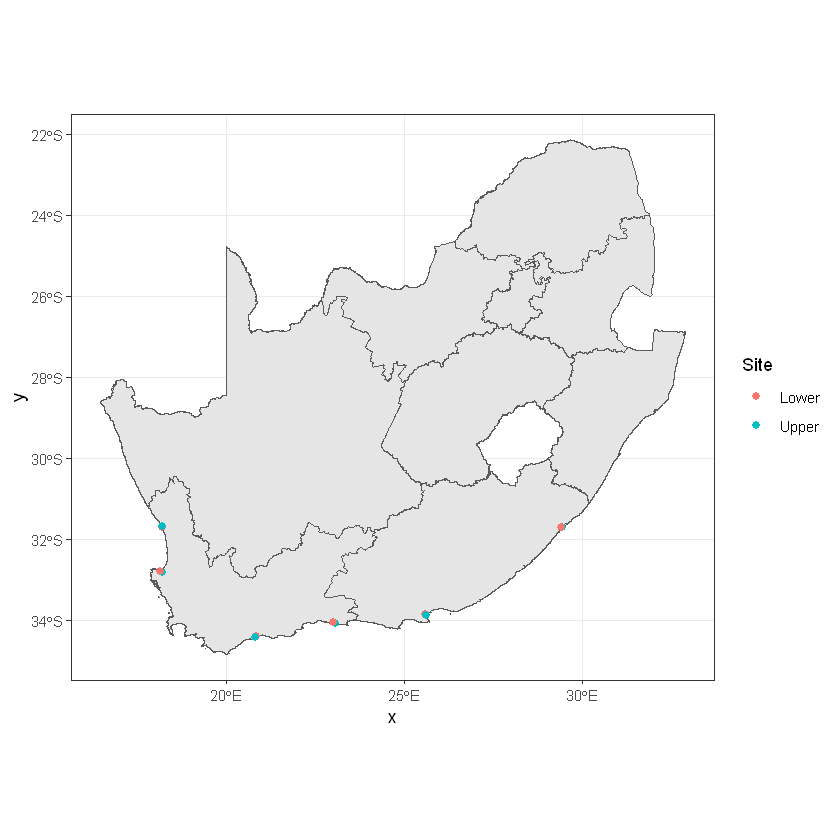

In [13]:
ggplot(data = ZA_admin1) +
   geom_sf() +
   geom_point(data = Bluecarbon_sites,
              position = position_dodge(width=0.2),
              aes(x = x,  y = y, colour = Site), size = 2) +
   theme_bw()

In [14]:
#setting options for smd data
options(sdmpredictors_datadir="C:/Users/andhlovu/Documents/Mzansi-Blue-Carbon/data/sdm")

In [15]:
sdm_datasets <- list_datasets(terrestrial = TRUE, marine = TRUE)

In [16]:
sdm_datasets

,dataset_code,terrestrial,marine,url,description,citation
,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>
1,WorldClim,TRUE,FALSE,http://www.worldclim.org/,"WorldClim is a set of global climate layers (climate grids). Note that all data has been transformed back to real values, so there is no need to e.g. divide temperature layers by 10.","Hijmans, R.J., S.E. Cameron, J.L. Parra, P.G. Jones and A. Jarvis, 2005. Very high resolution interpolated climate surfaces for global land areas. International Journal of Climatology 25: 1965-1978."
2,Bio-ORACLE,FALSE,TRUE,https://bio-oracle.org/,"Bio-ORACLE is a set of GIS rasters providing geophysical, biotic and environmental data for surface and benthic marine realms at a spatial resolution 5 arcmin (9.2 km) in the ESRI ascii and tif format.","Tyberghein L., Verbruggen H., Pauly K., Troupin C., Mineur F. & De Clerck O. Bio-ORACLE: a global environmental dataset for marine species distribution modeling. Global Ecology and Biogeography. doi: 10.1111/j.1466-8238.2011.00656.x"
3,MARSPEC,FALSE,TRUE,http://marspec.org/,"MARSPEC is a set of high resolution climatic and geophysical GIS data layers for the world ocean. Seven geophysical variables were derived from the SRTM30_PLUS high resolution bathymetry dataset. These layers characterize the horizontal orientation (aspect), slope, and curvature of the seafloor and the distance from shore. Ten ""bioclimatic"" variables were derived from NOAA's World Ocean Atlas and NASA's MODIS satellite imagery and characterize the inter-annual means, extremes, and variances in sea surface temperature and salinity. These variables will be useful to those interested in the spatial ecology of marine shallow-water and surface-associated pelagic organisms across the globe. Note that, in contrary to the original MARSPEC, all layers have unscaled values.","Sbrocco, EJ and Barber, PH (2013) MARSPEC: Ocean climate layers for marine spatial ecology. Ecology 94: 979. doi: 10.1890/12-1358.1"
4,ENVIREM,TRUE,FALSE,https://envirem.github.io/,"The ENVIREM dataset is a set of 16 climatic and 2 topographic variables that can be used in modeling species' distributions. The strengths of this dataset include their close ties to ecological processes, and their availability at a global scale, at several spatial resolutions, and for several time periods. The underlying temperature and precipitation data that went into their construction comes from the WorldClim dataset (www.worldclim.org), and the solar radiation data comes from the Consortium for Spatial Information (www.cgiar-csi.org). The data are compatible with and expand the set of variables from WorldClim v1.4 (www.worldclim.org).","Title, P.O., Bemmels, J.B. 2017. ENVIREM: An expanded set of bioclimatic and topographic variables increases flexibility and improves performance of ecological niche modeling. Ecography doi: 10.1111/ecog.02880."
5,Freshwater,TRUE,FALSE,https://www.earthenv.org/streams,"The dataset consists of near-global, spatially continuous, and freshwater-specific environmental variables in a standardized 1km grid. We delineated the sub-catchment for each grid cell along the HydroSHEDS river network and summarized the upstream environment (climate, topography, land cover, surface geology and soil) to each grid cell using various metrics (average, minimum, maximum, range, sum, inverse distance-weighted average and sum). All variables were subsequently averaged across single lakes and reservoirs of the Global lakes and Wetlands Database that are connected to the river network. Monthly climate variables were summarized into 19 long-term climatic variables following the ÒbioclimÓ framework.","Domisch, S., Amatulli, G., and Jetz, W. (2015) Near-global freshwater-specific environmental variables for biodiversity analyses in 1 km resolution. Scientific Data 2:150073 doi: 10.1038/sdata.2015.73"


In [17]:
sdm_datasets$dataset_code

[1] "WorldClim"  "Bio-ORACLE" "MARSPEC"    "ENVIREM"    "Freshwater"

In [18]:
environmental_layers <- sdmpredictors::list_layers(sdm_datasets)

In [19]:
ref_layer = sdmpredictors::list_layers(sdm_datasets)

In [20]:
colnames(environmental_layers)

[1] "dataset_code"               "layer_code"                
 [3] "name"                       "description"               
 [5] "terrestrial"                "marine"                    
 [7] "freshwater"                 "cellsize_equalarea"        
 [9] "cellsize_lonlat"            "units"                     
[11] "primary_type"               "primary_spatial_resolution"
[13] "primary_source"             "start_year"                
[15] "start_month"                "start_day"                 
[17] "end_year"                   "end_month"                 
[19] "end_day"                    "derivation"                
[21] "month"                      "is_surface"                
[23] "version"                    "layer_url"

In [21]:
WorldClim_list <- environmental_layers %>% dplyr::filter(is.na(month)) %>% dplyr::filter(dataset_code == "WorldClim") 
MARSPEC_list <- environmental_layers %>% dplyr::filter(is.na(month)) %>% dplyr::filter(dataset_code == "MARSPEC") 

In [22]:
WorldClim_layers <- sdmpredictors::load_layers(layercodes =  WorldClim_list$layer_code, equalarea=FALSE, rasterstack=TRUE)
MARSPEC_layers <- sdmpredictors::load_layers(layercodes =  MARSPEC_list$layer_code, equalarea=FALSE, rasterstack=TRUE)

In [23]:
ZA_extent <- raster::extent(10, 40, -37, -22)
WorldClim_cropped <- raster::crop(WorldClim_layers, ZA_extent) 
MARSPEC_cropped <- raster::crop(MARSPEC_layers, ZA_extent)  

In [24]:
Bluecarbon_sites

estuary,Site,x,y,date,Biogeographical_region
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
Berg,Upper,18.19648,-32.81314,18 06 2021,Cool Temperate
Berg,Lower,18.14189,-32.77216,18 06 2021,Cool Temperate
Breede,Lower,20.84452,-34.39693,25 06 2021,Warm temperate
Breede,Upper,20.80405,-34.40552,25 06 2021,Warm temperate
Knysna,Upper,23.05105,-34.06119,30 05 2021,Warm temperate
Knysna,Lower,22.99216,-34.03369,30 05 2021,Warm temperate
Olifants,Lower,18.18882,-31.69302,05 07 2021,Cool Temperate
Olifants,Upper,18.19545,-31.66071,05 07 2021,Cool Temperate
Swartkops,Lower,25.59069,-33.83784,25 05 2021,Warm temperate


In [25]:
WC_alt_layer <- WorldClim_cropped[[1]]
#env_layers_raw  <- stack(WorldClim_cropped, MARSPEC_cropped)
env_layers <-resample(WorldClim_cropped, WC_alt_layer, method = "ngb") 

In [26]:
# t <- extent(-180, 180, -90, 90) #layer extent from terrestrial stack
# m <- extent(-180, 180, -90, 90) #layer extent from marine stack
# #no need to edit the following 6 lines
# extent_list<-list(t, m)
# extent_list<-lapply(extent_list, as.matrix)
# matrix_extent<-matrix(unlist(extent_list), ncol=length(extent_list))
# rownames(matrix_extent)<-c("xmin", "ymin", "xmax", "ymax")
# best_extent<-extent(min(matrix_extent[1,]), max(matrix_extent[3,]), min(matrix_extent[2,]), max(matrix_extent[4,]))
# ranges<-apply(as.matrix(best_extent), 1, diff)
# reso <- res(WorldClim_cropped) #choose layer you want to keep resolution
# nrow_ncol <-ranges/reso
# raster_ref <-raster(best_extent, nrows=nrow_ncol[2], ncols=nrow_ncol[1], crs = WorldClim_layers@crs) #choose layer crs you want to keep

In [27]:
envs_data <- as.data.frame(raster::extract(env_layers, ZAF_bluecarbon_raw[c("x", "y")]))
colnames(envs_data)

[1] "WC_alt"   "WC_bio1"  "WC_bio2"  "WC_bio3"  "WC_bio4"  "WC_bio5" 
 [7] "WC_bio6"  "WC_bio7"  "WC_bio8"  "WC_bio9"  "WC_bio10" "WC_bio11"
[13] "WC_bio12" "WC_bio13" "WC_bio14" "WC_bio15" "WC_bio16" "WC_bio17"
[19] "WC_bio18" "WC_bio19"

In [28]:
envs_df <- as.data.frame(envs_data)

In [29]:
pca1 <- dudi.pca(envs_data, 
                 scannf = F, 
                 nf = 2)

In [30]:
str(pca1$li[,1:2])

'data.frame':	47 obs. of  2 variables:
 $ Axis1: num  -2.78 -2.78 -2.78 -2.78 -3.27 ...
 $ Axis2: num  -0.74 -0.74 -0.74 -0.74 -0.881 ...


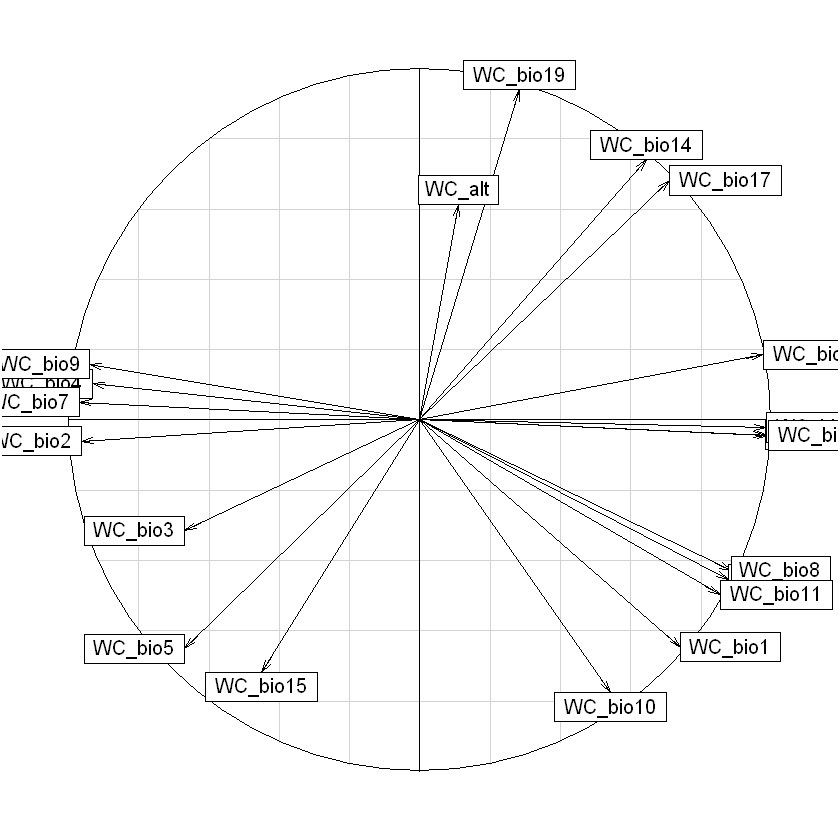

In [31]:
s.corcircle(pca1$co)

In [32]:
worldclim_ref <- environmental_layers[environmental_layers$layer_code %in% colnames(envs_data), c("layer_code","name","description", "start_year","end_year")]

In [33]:
colnames(environmental_layers)

[1] "dataset_code"               "layer_code"                
 [3] "name"                       "description"               
 [5] "terrestrial"                "marine"                    
 [7] "freshwater"                 "cellsize_equalarea"        
 [9] "cellsize_lonlat"            "units"                     
[11] "primary_type"               "primary_spatial_resolution"
[13] "primary_source"             "start_year"                
[15] "start_month"                "start_day"                 
[17] "end_year"                   "end_month"                 
[19] "end_day"                    "derivation"                
[21] "month"                      "is_surface"                
[23] "version"                    "layer_url"

In [34]:
colnames(envs_data)

[1] "WC_alt"   "WC_bio1"  "WC_bio2"  "WC_bio3"  "WC_bio4"  "WC_bio5" 
 [7] "WC_bio6"  "WC_bio7"  "WC_bio8"  "WC_bio9"  "WC_bio10" "WC_bio11"
[13] "WC_bio12" "WC_bio13" "WC_bio14" "WC_bio15" "WC_bio16" "WC_bio17"
[19] "WC_bio18" "WC_bio19"

In [35]:
worldclim_cor <- layers_correlation(colnames(envs_data))

In [36]:
high_cor <- findCorrelation(worldclim_cor, cutoff = .6, exact = FALSE, names = TRUE)
#worldclim_ref[worldclim_ref$layer_code %in% high_cor,]

In [37]:
`%nin%` <- Negate(`%in%`)

In [38]:
worldclim_best <- worldclim_ref$layer_code[worldclim_ref$layer_code %nin% high_cor]
#worldclim_ref[worldclim_ref$layer_code %in% worldclim_best,]

In [39]:
worldclim_ref[worldclim_ref$layer_code %in% worldclim_best,]$name

[1] "Altitude"                         "Mean diurnal temperature range"  
[3] "Maximum temperature"              "Precipitation of driest month"   
[5] "Precipitation seasonality"        "Precipitation of warmest quarter"

In [40]:
layers_correlation(worldclim_best)

,WC_alt,WC_bio2,WC_bio5,WC_bio14,WC_bio15,WC_bio18
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WC_alt,1.00000000,0.2520772,-0.33480275,-0.1361851,0.1751170,-0.05362687
WC_bio2,0.25207716,1.0000000,0.59690305,-0.4261057,0.4810320,-0.33629709
WC_bio5,-0.33480275,0.5969031,1.00000000,-0.1570814,0.4009150,-0.07711694
WC_bio14,-0.13618505,-0.4261057,-0.15708137,1.0000000,-0.5258624,0.56832546
WC_bio15,0.17511698,0.4810320,0.40091504,-0.5258624,1.0000000,-0.15937806
WC_bio18,-0.05362687,-0.3362971,-0.07711694,0.5683255,-0.1593781,1.00000000


In [41]:
colnames(ZAF_bluecarbon_raw)

[1] "estuary"                "Site"                   "Site_Id"               
 [4] "Site_ref"               "Core"                   "mean_Corg"             
 [7] "MgC_perHa"              "x"                      "y"                     
[10] "date"                   "Biogeographical_region"

In [42]:
ZAF_bluecarbon_final <- data.frame(ZAF_bluecarbon_raw)

for (layer_name in worldclim_best){ 
    
    layer <- env_layers[[layer_name]]
    
    ZAF_bluecarbon_final[layer_name] <- raster::extract(layer, ZAF_bluecarbon_raw[,c("x", "y")])
}

ZAF_bluecarbon_final <- ZAF_bluecarbon_final %>% dplyr::select(-c(WC_alt))

In [43]:
best_WC <- worldclim_ref[worldclim_ref$layer_code %in% worldclim_best,]

In [44]:
colnames(ZAF_bluecarbon_final)

[1] "estuary"                "Site"                   "Site_Id"               
 [4] "Site_ref"               "Core"                   "mean_Corg"             
 [7] "MgC_perHa"              "x"                      "y"                     
[10] "date"                   "Biogeographical_region" "WC_bio2"               
[13] "WC_bio5"                "WC_bio14"               "WC_bio15"              
[16] "WC_bio18"

In [1]:
?car::vif

In [2]:
citation("car")


To cite the car package in publications use:

  John Fox and Sanford Weisberg (2019). An {R} Companion to Applied
  Regression, Third Edition. Thousand Oaks CA: Sage. URL:
  https://socialsciences.mcmaster.ca/jfox/Books/Companion/

A BibTeX entry for LaTeX users is

  @Book{,
    title = {An {R} Companion to Applied Regression},
    edition = {Third},
    author = {John Fox and Sanford Weisberg},
    year = {2019},
    publisher = {Sage},
    address = {Thousand Oaks {CA}},
    url = {https://socialsciences.mcmaster.ca/jfox/Books/Companion/},
  }


In [45]:
fit1 <- lm(MgC_perHa ~ WC_bio2 + WC_bio14 + WC_bio15 + WC_bio18, data = ZAF_bluecarbon_final)
vif_out <-  as.data.frame(car::vif(fit1)) %>% tibble::rownames_to_column(var = "layer_code")
colnames(vif_out)[2] <- "VIF"
(final_layers <- merge(vif_out, best_WC) %>% filter(VIF < 10)) %>% 
                 dplyr::select(layer_code, name, description, description, start_year, end_year, VIF) %>%
                 dplyr::mutate(VIF = round(VIF,2))
print(xtable(final_layers, digits=2, type = "latex"), file = "Supplementary_material/Worldclim_data.tex", include.rownames=FALSE)

layer_code,name,description,start_year,end_year,VIF
<chr>,<chr>,<chr>,<int>,<int>,<dbl>
WC_bio14,Precipitation of driest month,Precipitation of driest month,1950,2000,9.24
WC_bio15,Precipitation seasonality,Coefficient of variation of the monthly precipitation,1950,2000,6.89
WC_bio18,Precipitation of warmest quarter,Precipitation of warmest quarter,1950,2000,7.75
WC_bio2,Mean diurnal temperature range,Mean of the monthly (maximum temperature - minimum temperature),1950,2000,7.40


In [46]:
layers_correlation(final_layers$layer_code)

,WC_bio14,WC_bio15,WC_bio18,WC_bio2
,<dbl>,<dbl>,<dbl>,<dbl>
WC_bio14,1.0000000,-0.5258624,0.5683255,-0.4261057
WC_bio15,-0.5258624,1.0000000,-0.1593781,0.4810320
WC_bio18,0.5683255,-0.1593781,1.0000000,-0.3362971
WC_bio2,-0.4261057,0.4810320,-0.3362971,1.0000000


In [47]:
ZAF_bluecarbon_final <- data.frame(ZAF_bluecarbon_raw)
for (layer_name in final_layers$layer_code){ 
    
    layer <- env_layers[[layer_name]]
    
    ZAF_bluecarbon_final[layer_name] <- raster::extract(layer, ZAF_bluecarbon_raw[,c("x", "y")])
}

ZAF_bluecarbon_final <- ZAF_bluecarbon_final %>% dplyr::select(-c("x", "y"))

In [48]:
#Without Swartkops estuary
#ZAF_bluecarbon_final <- ZAF_bluecarbon_final %>% 
#                       dplyr::filter(estuary != "Swartkops" | Site != "Lower") 

In [49]:
ref_numeric <- ZAF_bluecarbon_final %>% 
               dplyr::select_if(is.numeric) %>%
               dplyr::select(-c(mean_Corg, MgC_perHa)) %>%
               colnames()

Scaler <- caret::preProcess(ZAF_bluecarbon_final, method = list(center = ref_numeric, scale = ref_numeric))
ZAF_bluecarbon <- predict(Scaler, ZAF_bluecarbon_final)

In [50]:
#https://stats.stackexchange.com/questions/59879/logistic-regression-anova-chi-square-test-vs-significance-of-coefficients-ano

In [51]:
simple_lmer <- function(pred, response_var, random_fmla, data){
    
    fmla_p2 = paste(pred, random_fmla, sep = " + ")
    fmla = as.formula(paste(response_var, fmla_p2, sep = " ~ "))
    lm_fit <-  lmer(fmla, data = data, REML=FALSE)
    lmer_out <- broom::tidy(lm_fit)
    lmer_out$variable <- pred
     
    return(lmer_out)
}

In [52]:
simple_lmer_anova <- function(pred, response_var, random_fmla, data){
    
    fmla_p2 = paste(pred, random_fmla, sep = " + ")
    fmla = as.formula(paste(response_var, fmla_p2, sep = " ~ "))
    lm_fit <-  lmer(fmla, data = data, REML=FALSE)
    lmer_anova <- car::Anova(lm_fit, test="Chisq") 
    return(lmer_anova)
}

In [53]:
lmer_out <- lapply(ref_numeric, 
            simple_lmer, 
            response_var = "MgC_perHa",
            random_fmla = "(1|estuary:Site)",
            data = ZAF_bluecarbon_final)

In [54]:
lmer_anova_out <-  lapply(ref_numeric, 
                   simple_lmer_anova, 
                   response_var = "MgC_perHa",
                   random_fmla = "(1|estuary:Site)",
                   data = ZAF_bluecarbon_final)

In [55]:
(lmer_df <-  do.call(rbind, lmer_out) %>%
             data.frame() %>%
             dplyr::filter(effect == "fixed" & is.na(group) & term != "(Intercept)") %>%
             dplyr::select(variable, variable, p.value) %>% 
             mutate(signif = signif_annotate(p.value)) %>%
             arrange(variable) %>%
             rename(layer_code = variable))

layer_code,p.value,signif
<chr>,<dbl>,<noquote>
WC_bio14,0.4824652,NS
WC_bio15,0.2041286,NS
WC_bio18,0.6278462,NS
WC_bio2,0.4870360,NS


In [56]:
lmer_anova_df <-  do.call(rbind, lmer_anova_out) %>%
             data.frame() %>% tibble::rownames_to_column(var = "layer_code")
bioclim_results <- merge(lmer_anova_df, best_WC) %>% 
                   dplyr::select(description, Chisq, Df, Pr..Chisq.) %>% dplyr::rename(p_value = Pr..Chisq.)

In [57]:
xtabs(~ Biogeographical_region + estuary, data = ZAF_bluecarbon_final)

                      estuary
Biogeographical_region Olifants Berg Breede Knysna Swartkops Mngazana
        Cool Temperate        8    8      0      0         0        0
        Subtropical           0    0      0      0         0       11
        Warm temperate        0    0      4      8         8        0

In [58]:
ZAF_bluecarbon_final$Biogeographical_region <- factor(ZAF_bluecarbon_final$Biogeographical_region, levels = c('Cool Temperate', 'Warm temperate','Subtropical'))

In [59]:
ZAF_biogeograpy <- ZAF_bluecarbon_final %>%
                    group_by(Biogeographical_region) %>% 
                    rstatix::get_summary_stats(MgC_perHa) %>% 
                    dplyr::select(Biogeographical_region, n, mean, sd, se) %>%
                    dplyr::rename(n_Biogeography = n, mean_Biogeography = mean, sd_Biogeography = sd,  se_Biogeography = se)

In [60]:
baseline_bio <- gls(MgC_perHa ~ 1, data = ZAF_bluecarbon_final, method="ML")
random_bio <- lme(MgC_perHa ~ 1, random = ~1|Site_ref, data = ZAF_bluecarbon_final, method="ML")
anova(baseline_bio, random_bio)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
baseline_bio,"gls(model = MgC_perHa ~ 1, data = ZAF_bluecarbon_final, method = ""ML"")",1,2,509.6118,513.3121,-252.8059,,NA,NA
random_bio,"lme.formula(fixed = MgC_perHa ~ 1, data = ZAF_bluecarbon_final, random = ~1 | Site_ref, method = ""ML"")",2,3,428.7684,434.3189,-211.3842,1 vs 2,82.84337,8.881955e-20


In [61]:
fit_bio <- lmer(MgC_perHa ~  Biogeographical_region + (1|Site_ref),  data  = ZAF_bluecarbon_final)
(Bluecarbon_sites <- car::Anova(fit_bio, test="Chisq") %>%
          tibble::rownames_to_column(var = "description") %>%
          dplyr::rename(p_value = "Pr(>Chisq)"))

description,Chisq,Df,p_value
<chr>,<dbl>,<dbl>,<dbl>
Biogeographical_region,1.322337,2,0.5162478


In [62]:
(env_results <- rbind(Bluecarbon_sites, bioclim_results) %>% 
               dplyr::mutate(p_value = round(p_value, 4), Chisq = round(Chisq, 2)))
#print(xtable(env_results, digits=2), type = "html", file = "Table/env_stats.html", include.rownames=FALSE)
print(xtable(env_results, digits=7, type = "latex"), file = "Supplementary_material/env_stats.tex", include.rownames=FALSE)

description,Chisq,Df,p_value
<chr>,<dbl>,<dbl>,<dbl>
Biogeographical_region,1.32,2,0.5162
Precipitation of driest month,0.53,1,0.4673
Coefficient of variation of the monthly precipitation,1.82,1,0.1770
Precipitation of warmest quarter,0.25,1,0.6180
Mean of the monthly (maximum temperature - minimum temperature),0.52,1,0.4720


In [63]:
dim(ZAF_bluecarbon_final)

[1] 47 13

In [64]:
glht_bio <- glht(fit_bio, linfct = mcp(Biogeographical_region = "Tukey"))
cld_bio <- multcomp::cld(glht_bio)
cld_bio <- cld_bio$mcletters$Letters %>% 
                 data.frame() %>%
                 setNames("cld_Biogeographical_region") %>%
                 tibble::rownames_to_column(var = "Biogeographical_region")

In [65]:
(table_biogeography1 <- merge(ZAF_biogeograpy, cld_bio) %>%
                       dplyr::mutate(n_Biogeography = glue::glue("({n_Biogeography})")))

Biogeographical_region,n_Biogeography,mean_Biogeography,sd_Biogeography,se_Biogeography,cld_Biogeographical_region
<fct>,<glue>,<dbl>,<dbl>,<dbl>,<chr>
Cool Temperate,(16),14.272,10.587,2.647,a
Subtropical,(11),46.183,25.299,7.628,a
Warm temperate,(20),58.072,73.875,16.519,a


In [66]:
anno_biogeography1 <-  ZAF_bluecarbon_final %>% 
                       dplyr::group_by(Biogeographical_region) %>%
                       dplyr::summarise(y1 = max(MgC_perHa) + 15,  y2 = y1 + 20) %>%
                       dplyr::ungroup() %>%
                       dplyr::mutate(x = row_number())

(biogeography_anno1 <-  merge(anno_biogeography1, table_biogeography1))

Biogeographical_region,y1,y2,x,n_Biogeography,mean_Biogeography,sd_Biogeography,se_Biogeography,cld_Biogeographical_region
<fct>,<dbl>,<dbl>,<int>,<glue>,<dbl>,<dbl>,<dbl>,<chr>
Cool Temperate,57.08164,77.08164,1,(16),14.272,10.587,2.647,a
Subtropical,122.04617,142.04617,3,(11),46.183,25.299,7.628,a
Warm temperate,246.29141,266.29141,2,(20),58.072,73.875,16.519,a


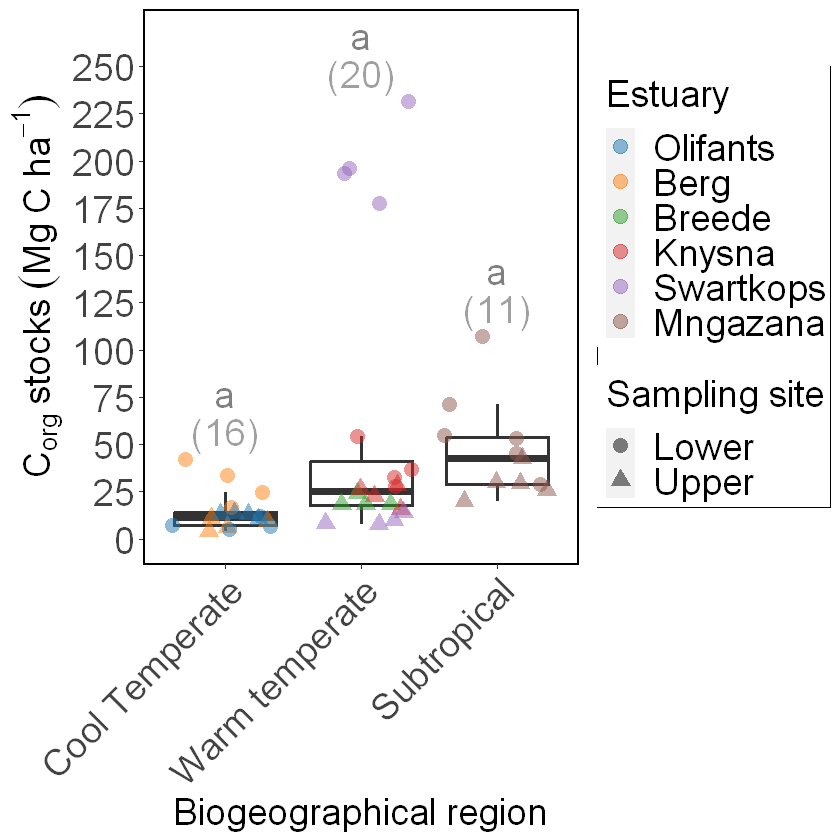

In [67]:
p1 <- ggplot(data = ZAF_bluecarbon_final %>% 
             dplyr::rename(Estuary = estuary, `Sampling site` = Site)) +
      geom_boxplot(aes(y = MgC_perHa,
                      x = Biogeographical_region),
                      outlier.alpha = 0,
                      linewidth = 1) +
     geom_point(aes(y = MgC_perHa,
                x = Biogeographical_region,
                colour = Estuary,
                shape = `Sampling site`,
                fill = Estuary),
                size = 4,
                alpha = 0.5,
               position = "jitter") +
      labs(x  = "Biogeographical region",  y = expression(paste(C[org]~stocks~(Mg~C~ha^{-1})))) +
      scale_y_continuous(limits = c(0, 267), breaks = seq(0, 267, 25)) +
      theme(panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.box.background = element_rect(colour = "black"),
            legend.title = element_text(size=22, colour = "black"),
            legend.text = element_text(size=22, colour = "black"),
            axis.text.y = element_text(size=22, colour = "#434343"),
            axis.text.x = element_text(hjust = 1, size=22, colour = "#434343", angle = 45),
            axis.title = element_text(size=22, colour = "black"),
            panel.border = element_rect(colour = "black", fill=NA, linewidth=1)) +
      geom_text(data = biogeography_anno1,
               aes(label = n_Biogeography,
                   y = y1,
                   x = x),
                   size = 8,
                   alpha = 0.75,
                   colour = "#808080") +
      geom_text(data = biogeography_anno1,
               aes(label = cld_Biogeographical_region,
                   y = y2,
                   x = x),
                   size = 8,
                   colour = "#808080") +
      ggsci::scale_color_d3()

p1
ggsave("Figurex/biogeo.pdf", height = 10,  width = 7.5)

In [68]:
######################################################################################################

                                  ####  REDUCED DATASET ####

######################################################################################################

In [69]:
#Without Swartkops estuary
ZAF_bluecarbon_final2 <- ZAF_bluecarbon_final %>% 
                       dplyr::filter(estuary != "Swartkops" | Site != "Lower") 

In [70]:
ZAF_biogeograpy2 <- ZAF_bluecarbon_final2 %>%
                    group_by(Biogeographical_region) %>% 
                    rstatix::get_summary_stats(MgC_perHa) %>% 
                    dplyr::select(Biogeographical_region, n, mean, sd, se) %>%
                    dplyr::rename(n_Biogeography = n, mean_Biogeography = mean, sd_Biogeography = sd,  se_Biogeography = se)

In [71]:
ref_numeric <- ZAF_bluecarbon_final %>% 
               dplyr::select_if(is.numeric) %>%
               dplyr::select(-c(mean_Corg, MgC_perHa)) %>%
               colnames()

Scaler <- caret::preProcess(ZAF_bluecarbon_final2, method = list(center = ref_numeric, scale = ref_numeric))
ZAF_bluecarbon <- predict(Scaler, ZAF_bluecarbon_final2)

In [72]:
#https://stats.stackexchange.com/questions/59879/logistic-regression-anova-chi-square-test-vs-significance-of-coefficients-ano

In [73]:
simple_lmer <- function(pred, response_var, random_fmla, data){
    
    fmla_p2 = paste(pred, random_fmla, sep = " + ")
    fmla = as.formula(paste(response_var, fmla_p2, sep = " ~ "))
    lm_fit <-  lmer(fmla, data = data, REML=FALSE)
    lmer_out <- broom::tidy(lm_fit)
    lmer_out$variable <- pred
     
    return(lmer_out)
}

In [74]:
simple_lmer_anova <- function(pred, response_var, random_fmla, data){
    
    fmla_p2 = paste(pred, random_fmla, sep = " + ")
    fmla = as.formula(paste(response_var, fmla_p2, sep = " ~ "))
    lm_fit <-  lmer(fmla, data = data, REML=FALSE)
    lmer_anova <- car::Anova(lm_fit, test="Chisq") 
    return(lmer_anova)
}

In [75]:
lmer_out <- lapply(ref_numeric, 
            simple_lmer, 
            response_var = "MgC_perHa",
            random_fmla = "(1|estuary:Site)",
            data = ZAF_bluecarbon_final2)

In [76]:
lmer_anova_out <-  lapply(ref_numeric, 
                   simple_lmer_anova, 
                   response_var = "MgC_perHa",
                   random_fmla = "(1|estuary:Site)",
                   data = ZAF_bluecarbon_final)

In [77]:
(lmer_df <-  do.call(rbind, lmer_out) %>%
             data.frame() %>%
             dplyr::filter(effect == "fixed" & is.na(group) & term != "(Intercept)") %>%
             dplyr::select(variable, variable, p.value) %>% 
             mutate(signif = signif_annotate(p.value)) %>%
             arrange(variable) %>%
             rename(layer_code = variable))

layer_code,p.value,signif
<chr>,<dbl>,<noquote>
WC_bio14,0.111480218,NS
WC_bio15,0.348700014,NS
WC_bio18,0.004350674,**
WC_bio2,0.003259311,**


In [78]:
lmer_anova_df <-  do.call(rbind, lmer_anova_out) %>%
             data.frame() %>% tibble::rownames_to_column(var = "layer_code")
bioclim_results <- merge(lmer_anova_df, best_WC) %>% 
                   dplyr::select(description, Chisq, Df, Pr..Chisq.) %>% dplyr::rename(p_value = Pr..Chisq.)

In [79]:
baseline_bio <- gls(MgC_perHa ~ 1, data = ZAF_bluecarbon_final, method="ML")
random_bio <- lme(MgC_perHa ~ 1, random = ~1|Site_ref, data = ZAF_bluecarbon_final, method="ML")
anova(baseline_bio, random_bio)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
baseline_bio,"gls(model = MgC_perHa ~ 1, data = ZAF_bluecarbon_final, method = ""ML"")",1,2,509.6118,513.3121,-252.8059,,NA,NA
random_bio,"lme.formula(fixed = MgC_perHa ~ 1, data = ZAF_bluecarbon_final, random = ~1 | Site_ref, method = ""ML"")",2,3,428.7684,434.3189,-211.3842,1 vs 2,82.84337,8.881955e-20


In [87]:
fit_bio <- lmer(MgC_perHa ~  Biogeographical_region + (1|Site_ref),  data  = ZAF_bluecarbon_final2)
(Bluecarbon_sites <- car::Anova(fit_bio, test="Chisq") %>%
          tibble::rownames_to_column(var = "description") %>%
          dplyr::rename(p_value = "Pr(>Chisq)"))

description,Chisq,Df,p_value
<chr>,<dbl>,<dbl>,<dbl>
Biogeographical_region,7.557347,2,0.02285298


In [88]:
(env_results <- rbind(Bluecarbon_sites, bioclim_results) %>% 
               dplyr::mutate(p_value = round(p_value, 4), Chisq = round(Chisq, 2)))
#print(xtable(env_results, digits=2), type = "html", file = "Table/env_stats.html", include.rownames=FALSE)
print(xtable(env_results, digits=7, type = "latex"), file = "Supplementary_material/env_stats.tex", include.rownames=FALSE)

description,Chisq,Df,p_value
<chr>,<dbl>,<dbl>,<dbl>
Biogeographical_region,7.56,2,0.0229
Precipitation of driest month,0.53,1,0.4673
Coefficient of variation of the monthly precipitation,1.82,1,0.1770
Precipitation of warmest quarter,0.25,1,0.6180
Mean of the monthly (maximum temperature - minimum temperature),0.52,1,0.4720


In [89]:
glht_bio <- glht(fit_bio, linfct = mcp(Biogeographical_region = "Tukey"))
cld_bio <- multcomp::cld(glht_bio)
cld_bio <- cld_bio$mcletters$Letters %>% 
                 data.frame() %>%
                 setNames("cld_Biogeographical_region") %>%
                 tibble::rownames_to_column(var = "Biogeographical_region")

In [90]:
table_biogeography2 <- merge(ZAF_biogeograpy2, cld_bio) %>%
                       dplyr::mutate(n_Biogeography = glue::glue("({n_Biogeography})"))

In [91]:
anno_biogeography2 <-   ZAF_bluecarbon_final2 %>% 
                        dplyr::group_by(Biogeographical_region) %>%
                        dplyr::summarise(y1 = max(MgC_perHa) + 10,  y2 = y1 + 10) %>%
                        dplyr::ungroup() %>%
                        dplyr::mutate(x = row_number())

(biogeography_anno2 <-  merge(anno_biogeography2, table_biogeography2))

Biogeographical_region,y1,y2,x,n_Biogeography,mean_Biogeography,sd_Biogeography,se_Biogeography,cld_Biogeographical_region
<fct>,<dbl>,<dbl>,<int>,<glue>,<dbl>,<dbl>,<dbl>,<chr>
Cool Temperate,52.08164,62.08164,1,(16),14.272,10.587,2.647,a
Subtropical,117.04617,127.04617,3,(11),46.183,25.299,7.628,b
Warm temperate,64.08644,74.08644,2,(16),22.713,11.897,2.974,ab


In [97]:
biogeography_anno1

Biogeographical_region,y1,y2,x,n_Biogeography,mean_Biogeography,sd_Biogeography,se_Biogeography,cld_Biogeographical_region
<fct>,<dbl>,<dbl>,<int>,<glue>,<dbl>,<dbl>,<dbl>,<chr>
Cool Temperate,57.08164,77.08164,1,(16),14.272,10.587,2.647,a
Subtropical,122.04617,142.04617,3,(11),46.183,25.299,7.628,a
Warm temperate,246.29141,266.29141,2,(20),58.072,73.875,16.519,a


In [92]:
p2 <- ggplot(data = ZAF_bluecarbon_final2 %>% dplyr::rename(Estuary = estuary)) +
      geom_boxplot(aes(y = MgC_perHa,
                      x = Biogeographical_region),
                      outlier.alpha = 0,
                      linewidth = 1) +
     geom_point(aes(y = MgC_perHa,
                x = Biogeographical_region,
                colour = Estuary,
                fill = Estuary),
                size = 4,
                alpha = 0.5,
               position = "jitter") +
      labs(x  = "Biogeographical region",  y = expression(paste(C[org]~stocks~(Mg~C~ha^{-1})))) +
      scale_y_continuous(limits = c(0, 150), breaks = seq(0, 125, 25)) +
      theme(panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            legend.box.background = element_rect(colour = "black"),
            legend.title = element_text(size=22, colour = "black"),
            legend.text = element_text(size=22, colour = "black"),
            axis.text.y = element_text(size=22, colour = "#434343"),
            axis.text.x = element_text(hjust = 1, size=22, colour = "#434343", angle = 45),
            axis.title = element_text(size=22, colour = "black"),
            panel.border = element_rect(colour = "black", fill=NA, linewidth=1)) +
      geom_text(data = biogeography_anno2,
               aes(label = n_Biogeography,
                   y = y1,
                   x = x),
                   size = 8,
                   alpha = 0.75,
                   colour = "#808080") +
      geom_text(data = biogeography_anno2,
               aes(label = cld_Biogeographical_region,
                   y = y2,
                   x = x),
                   size = 8,
                   colour = "#808080") +
      ggsci::scale_color_d3()

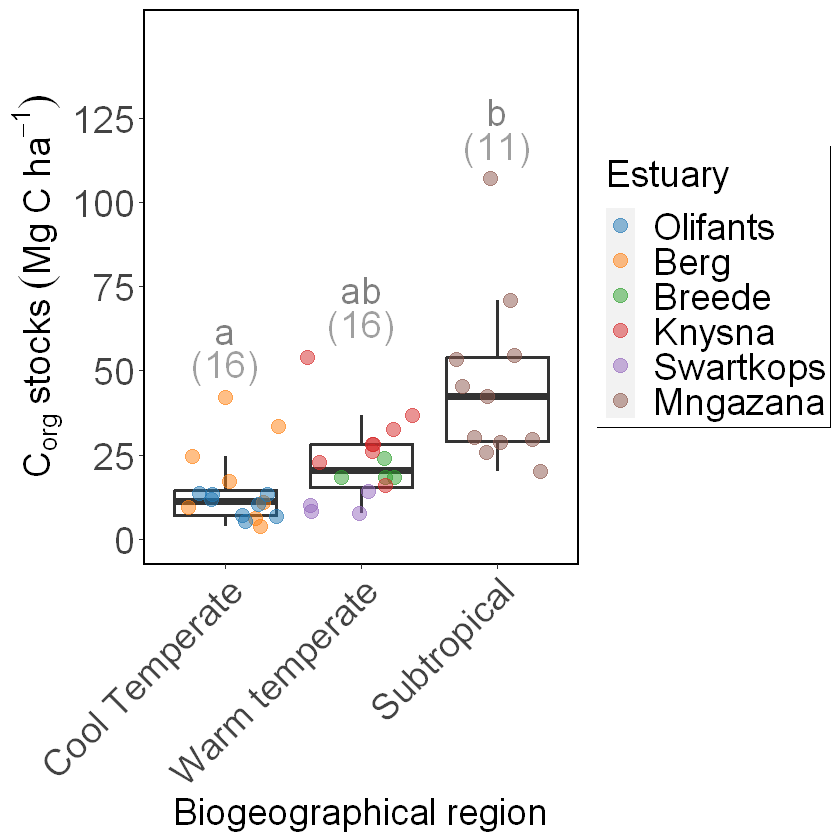

In [93]:
p2

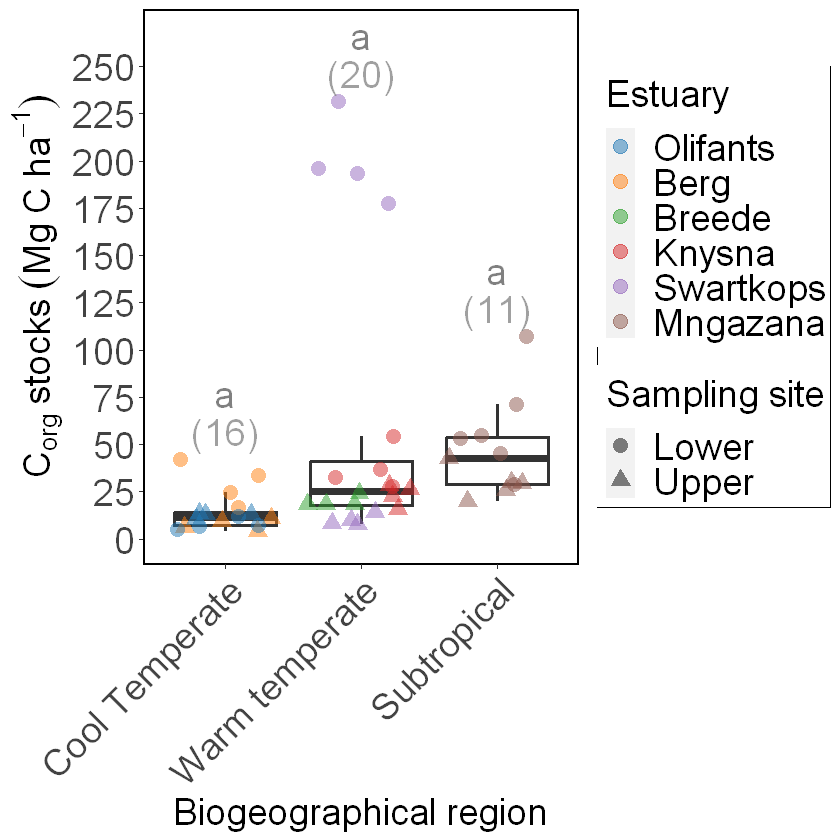

In [94]:
p1

In [96]:
fit_bio2 <- lmer(MgC_perHa ~  Biogeographical_region + (1|Site_ref),  data  = ZAF_bluecarbon_final2)
summary(fit_bio2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: MgC_perHa ~ Biogeographical_region + (1 | Site_ref)
   Data: ZAF_bluecarbon_final2

REML criterion at convergence: 331.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4114 -0.3415 -0.1743  0.1639  4.0834 

Random effects:
 Groups   Name        Variance Std.Dev.
 Site_ref (Intercept) 138.4    11.77   
 Residual             145.6    12.07   
Number of obs: 43, groups:  Site_ref, 10

Fixed effects:
                                     Estimate Std. Error     df t value
(Intercept)                            14.272      6.611  7.343   2.159
Biogeographical_regionWarm temperate    8.441      9.350  7.343   0.903
Biogeographical_regionSubtropical      30.752     11.236  6.808   2.737
                                     Pr(>|t|)  
(Intercept)                            0.0659 .
Biogeographical_regionWarm temperate   0.3953  
Biogeographical_regionSubtropical      0.0299 *
---
Sign